In [23]:
!ls

MURA-v1.1  sample_data


In [0]:
# -*- coding: utf-8 -*-

In [0]:

# !wget -c https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip
# !unzip MURA-v1.1.zip
# !rm MURA-v1.1.zip
# !ls


In [0]:
#leave this here don't ask why
drivee=""

In [0]:
# ## If the drive thing didn't work unzip the downloaded files to a folder and give its name to directory
# from google.colab import drive
# drive.mount('/content/drive')
# drivee="drive/My Drive/"

In [0]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import keras
pd.options.display.max_colwidth = 100
from keras.applications.mobilenetv2 import MobileNetV2
from keras.applications.densenet import DenseNet169
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.nasnet import NASNetMobile
from keras.preprocessing import image
from keras.applications.mobilenetv2 import preprocess_input
from keras.applications import MobileNet
from keras.callbacks import (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard)
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.metrics import binary_accuracy, binary_crossentropy
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenetv2 import MobileNetV2
from keras.preprocessing import image as k_im_prep
from keras.models import Model
from keras import backend as K
from keras.models import Sequential

from sklearn.metrics import confusion_matrix
import itertools


In [0]:
def paths_n_labels(csv,str_limp):
    #make dataframe
    print(csv)
    studies=pd.read_csv(csv, sep=',',header=None)
    #separate study paths and labels of given limp from those of other limps
    limp_studies=studies[studies[0].str.contains(str_limp)==True]
    #make it a numpy
    limp_studies=np.array(limp_studies)
    #limp study folder paths
    limp_paths=[]
    #labels of given limp
    limp_labels=[]
    for i in tqdm( range(limp_studies.shape[0]) ):
        study_path= drivee + limp_studies[i][0]
        study_label=limp_studies[i][1]
        study_files = [f for f in listdir(study_path) if isfile(join(study_path, f))]
        for image in study_files:
            limp_paths.append(study_path + image)
            limp_labels.append(study_label)

    limp_paths=np.array(limp_paths)
    limp_labels=np.array(limp_labels)

    return limp_paths,limp_labels

In [0]:
#general function with options for wrist data case, only set wrist_train=True in the case of wrist training data only
#for all other limps and for validation data even that of wrist just pass the paths
#targ_size is image resizing with default(224,224)
#preprocess flag is for using keras preprocessing for images or just resizing
def read_images(paths ,targ_size= (224, 224), wrist_train=False, preprocess=False):
    images=[]
    #load any limp images
    if(not wrist_train):
        for path in tqdm(paths):
            img=k_im_prep.load_img(path, target_size=targ_size )
            if(preprocess):
                img = k_im_prep.img_to_array(img)
                img = np.expand_dims(img, axis=0)
                img = preprocess_input(img)
                images.append(np.array(img)[0])
            else:
              images.append(np.array(img))
    #special case for wrist train corrupted data       
    else:
        #did this because it gave an error at sample  5307 or near it if took all
        sample_e=5307
        sample_s2=5339
        images=[]
        for path in tqdm(paths[:sample_e]):
            img=k_im_prep.load_img(path, target_size=targ_size)
            if(preprocess):
                img = k_im_prep.img_to_array(img)
                img = np.expand_dims(img, axis=0)
                img = preprocess_input(img)
                images.append(np.array(img)[0])
            else:
              images.append(np.array(img))

        #new start
        for path in tqdm(paths[sample_s2:]):
            img=k_im_prep.load_img(path, target_size=targ_size)
            if(preprocess):
                img = k_im_prep.img_to_array(img)
                img = np.expand_dims(img, axis=0)
                img = preprocess_input(img)
                images.append(np.array(img)[0])
            else:
              images.append(np.array(img))

    #making it a numpy array instead of python list
    return (np.array(images))
  

def wrist_labels(labels):
  sample_e=5307
  sample_s2=5339
  return np.hstack( [ labels[:sample_e], labels[sample_s2:] ])


In [0]:
train_studies=drivee+'MURA-v1.1/train_labeled_studies.csv'
valid_studies=drivee+'MURA-v1.1/valid_labeled_studies.csv'

In [0]:
 def images_n_labels(limp,preprocess=True):
  
  print("\nreading studies of "+ limp + "\n")
  print(train_studies)
  train_paths,train_labels=paths_n_labels(train_studies,limp)
  valid_paths,valid_labels=paths_n_labels(valid_studies,limp)
  
  print(train_labels.shape)
  print(valid_labels.shape)
  print("reading "+ limp + " training images")
  if (limp == "WRIST"):
    train_labels=wrist_labels(train_labels)
    train_imgs= read_images(train_paths,preprocess=preprocess, wrist_train=True)
    
  else:
    train_imgs= read_images(train_paths,preprocess=preprocess, wrist_train=False)
  print(train_imgs.shape)  
  print("reading "+ limp + " validation images")
  valid_imgs= read_images(valid_paths,preprocess=True)
  print(valid_imgs.shape)
  
  return train_imgs, train_labels, valid_imgs, valid_labels

In [0]:
def make_FT_model(base=1, imagenet=True, freeze_all=True, add_denses=1):
  
  #weights of pretrained model
  if (imagenet==True):
    w='imagenet'
  else:
    w=None
  
  #default because refrenced before assignment error, just scroll down
  base_model = MobileNetV2(input_shape= (224, 224, 3),weights=w, include_top=False)
  
  #initializing pretrained model
  if (base==0):
    base_model = MobileNetV2(input_shape= (224, 224, 3),weights=w, include_top=False)
  elif (base == 1):
    base_model = DenseNet169(input_shape= (224, 224, 3),weights=w, include_top=False)
  elif (base == 2):
    base_model = InceptionV3(input_shape= (224, 224, 3),weights=w, include_top=False)
  elif (base == 3):
    base_model = ResNet50(input_shape= (224, 224, 3),weights=w, include_top=False)   
  elif (base == 4):
    base_model = NASNetMobile(input_shape= (224, 224, 3),weights=w, include_top=False)
    
 
  if (freeze_all):
    #freeze layers of densenet
    for layer in base_model.layers:
      layer.trainable= False 
  
  # add a global spatial average pooling layer
  x = base_model.output
  x = GlobalAveragePooling2D()(x)

  if(add_denses > 0):
      # let's add a fully-connected layer
      #x = Dense(1024, activation='relu')(x)
      x = Dense(512, activation='relu')(x)
  if(add_denses > 1):  
      x = Dense(128, activation='relu')(x)
      #x = Dense(32, activation='relu')(x)
      # and a logistic layer -- let's say we have 200 classes
  predictions = Dense(1, activation='sigmoid')(x)
  # this is the model we will train
  model = Model(inputs=base_model.input, outputs=predictions)

  if(add_denses == 0):
    # just feature extractor
    model = Model(inputs=base_model.input, output=x)

  
  return model

In [0]:
#parameter setting for experiment
#choose here which limps to use when running the function
#limps=[ "ELBOW", "FINGER", "FOREARM", "HUMERUS","HAND", "SHOULDER", "WRIST"]
LIMPS=["HUMERUS"]

# which Transfer Learning base models to use
BASE=[0]
#this is just to know index of each model when choosing base above and to print it when running the function
bases=["MobileNetV2", "DenseNet169", "InceptionV3", "ResNet50","NASNetMobile"]


# whether to use imagenet weights of not
IMAGENET=True


# whether to freeze ALL layers of base model or not
FREEZE=False


# how much information to display about epochs and progress , 0= none , 1 is line per epoch
VERBOSE=1


# whether to preprocess input 
PREPROCESS=True


#whether to augment data
AUGMENTATION=False

EPOCH=5
BATCH=64



In [34]:
limp="HUMERUS"
train_imgs, train_labels, valid_imgs, valid_labels= images_n_labels(limp, preprocess=PREPROCESS)

  1%|▏         | 19/1272 [00:00<00:06, 183.57it/s]


reading studies of HUMERUS

MURA-v1.1/train_labeled_studies.csv
MURA-v1.1/train_labeled_studies.csv
MURA-v1.1/valid_labeled_studies.csv
(1272,)
(288,)
reading HUMERUS training images


  6%|▋         | 18/288 [00:00<00:01, 178.24it/s]

(1272, 224, 224, 3)
reading HUMERUS validation images


100%|██████████| 288/288 [00:02<00:00, 111.18it/s]


(288, 224, 224, 3)


In [35]:
#run this before runnning reading again
print(train_labels[0])

1


In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [0]:
datagen = ImageDataGenerator(  rescale=1./255,
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,
    zoom_range=0.1,
    channel_shift_range=0.,
    fill_mode='nearest')

In [0]:
#pass to model list of limps because if wanted to train on less
#function outputs a dictionary or dataframe has train and val accuracies for each limp using a chosen model



def evaluate_limps(models=[1],epoch=5,batch=32, imagenet=True, freeze_all=False,v=1 ,
                   limps=["WRIST"], preprocess_ip=True, augment=False):
    
    accuracies={}
    batch_aug_size=64
    for model in models:
        print("\n\n used base model: \n\n"+bases[model])
        for limp in limps:
            #print("reading "+ limp + " images\n")
            #train_imgs, train_labels, valid_imgs, valid_labels= images_n_labels(limp, preprocess=preprocess_ip)
            
            print("making model")
            model=make_FT_model(base= model, imagenet=imagenet, freeze_all=freeze_all, add_denses=1)
            
            print("compiling")
            model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

            unique, counts = np.unique(train_labels, return_counts=True)
            print("normal ,abnormal :")
            print(counts)
            zero_w=counts[1]/np.sum(counts)
            one_w=1-zero_w
            print("zero and one weights",zero_w,one_w)
            
            ##############################################################

            if(augment): #dataaugmentation model fitting
              print("Augmenting Input data")
              # # compute quantities required for featurewise normalization
              # # (std, mean, and principal components if ZCA whitening is applied)

              datagen.fit(train_imgs)
              model.fit_generator(datagen.flow(train_imgs, train_labels, batch_size=batch_aug_size),
                            steps_per_epoch=len(train_imgs) / (batch_aug_size), epochs=7,validation_data=(valid_imgs, valid_labels))
              print("training augmentation calculations for "+ limp)

              loss_tr, accuracy_tr =model.evaluate_generator(datagen.flow(train_imgs,train_labels),steps=len(valid_imgs) / batch_aug_size)

              print("calculating validation augmentation loss for "+ limp)

              loss_val, accuracy_val = model.evaluate_generator(datagen.flow(valid_imgs,valid_labels),steps=len(valid_imgs) / batch_aug_size)

              accuracies.update( {limp : [accuracy_tr, accuracy_val]} )

#               print(model.predict(valid_imgs, batch_size=batch_aug_size))
              print(accuracies)

            ###############################################################
            else:

              print("fitting")
              model.fit(train_imgs, train_labels, epochs=epoch, validation_data=(valid_imgs, valid_labels),
                      shuffle=True, verbose=v, batch_size=batch, class_weight={0: zero_w, 1: one_w} )
            
            
            
            
            y_pred=model.predict(valid_imgs)
            y_pred[y_pred >=0.5]=1
            y_pred[y_pred <0.5]=0
            #     print(y_pred)
            #y_pred=np.argmax(y_pred, axis=1)

            y_pred_for_training=model.predict(train_imgs)
            y_pred_for_training[y_pred_for_training >=0.5]=1
            y_pred_for_training[y_pred_for_training < 0.5]=0

            
            print("second prediction vlayes")
            print(y_pred)

            # Compute confusion matrix
            cnf_matrix = confusion_matrix(valid_labels, y_pred)

            cnf_matrix2 = confusion_matrix(train_labels, y_pred_for_training)

            np.set_printoptions(precision=2)

            cm_class_label = ['Normal','abnormal']
            # Plot non-normalized confusion matrix
            plt.figure()
            plot_confusion_matrix(cnf_matrix,cm_class_label,title='Confusion matrix for valiadation set')
            #plot_confusion_matrix(cnf_matrix2,cm_class_label,title='Confusion matrix for training set')

            
            print("training loss calculations for "+ limp)
            loss_tr, accuracy_tr =model.evaluate(x=train_imgs, y=train_labels, batch_size=BATCH, verbose=v)

            print("calculating validation loss for "+ limp)
            loss_val, accuracy_val =model.evaluate(x=valid_imgs, y=valid_labels, batch_size=BATCH, verbose=v)

            print("validation predictions for testing")

            #valid_preds=model.predict(valid_imgs)
            valid_preds=y_pred
            print( np.unique(y_pred) )

            accuracies.update( {limp : [accuracy_tr, accuracy_val]} )
            print("\n \n "+ limp)
            print(accuracies)
            print("train ratio of abnormal predictions to # abnormal samples")
            print(np.sum( model.predict(train_imgs) )/np.sum(train_labels))
            print("valid ratio of abnormal predictions")
            print(np.sum(valid_preds) / np.sum(valid_labels))
            pd.DataFrame(accuracies).head(2)
            
            
            
    return accuracies

  
  



 used base model: 

MobileNetV2
making model
compiling
normal ,abnormal :
[673 599]
zero and one weights 0.47091194968553457 0.5290880503144655
fitting
Train on 1272 samples, validate on 288 samples
Epoch 1/5
1272/1272 [==============================] - 68s 54ms/step - loss: 0.2931 - acc: 0.7138 - val_loss: 0.5547 - val_acc: 0.7882
Epoch 2/5
1272/1272 [==============================] - 16s 13ms/step - loss: 0.1841 - acc: 0.8451 - val_loss: 0.6938 - val_acc: 0.7604
Epoch 3/5
1272/1272 [==============================] - 16s 13ms/step - loss: 0.1007 - acc: 0.9182 - val_loss: 1.7705 - val_acc: 0.6181
Epoch 4/5
1272/1272 [==============================] - 16s 13ms/step - loss: 0.1151 - acc: 0.9041 - val_loss: 0.8882 - val_acc: 0.7500
Epoch 5/5
1272/1272 [==============================] - 16s 13ms/step - loss: 0.0790 - acc: 0.9418 - val_loss: 0.9589 - val_acc: 0.7431
second prediction vlayes
[[0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1

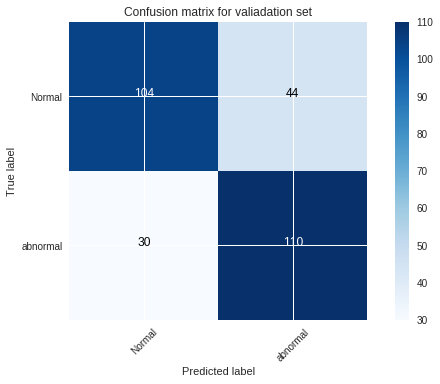

In [52]:
R=evaluate_limps(models=BASE,epoch=EPOCH,batch=BATCH, imagenet=IMAGENET, freeze_all=FREEZE,
                 v=VERBOSE, limps=LIMPS, preprocess_ip=PREPROCESS, augment=AUGMENTATION)


In [0]:
def make_FT_model(base=1, imagenet=True, freeze_all=True, add_denses=1):
  
  #weights of pretrained model
  if (imagenet==True):
    w='imagenet'
  else:
    w=None
  
  #default because refrenced before assignment error, just scroll down
  base_model = MobileNetV2(input_shape= (224, 224, 3),weights=w, include_top=False)
  
  #initializing pretrained model
  if (base==0):
    base_model = MobileNetV2(input_shape= (224, 224, 3),weights=w, include_top=False)
  elif (base == 1):
    base_model = DenseNet169(input_shape= (224, 224, 3),weights=w, include_top=False)
  elif (base == 2):
    base_model = InceptionV3(input_shape= (224, 224, 3),weights=w, include_top=False)
  elif (base == 3):
    base_model = ResNet50(input_shape= (224, 224, 3),weights=w, include_top=False)   
  elif (base == 4):
    base_model = NASNetMobile(input_shape= (224, 224, 3),weights=w, include_top=False)
    
 
  if (freeze_all):
    #freeze layers of densenet
    for layer in base_model.layers:
      layer.trainable= False 
  
  # add a global spatial average pooling layer
  x = base_model.output
  x = GlobalAveragePooling2D()(x)

  if(add_denses > 0):
      # let's add a fully-connected layer
      #x = Dense(1024, activation='relu')(x)
      x = Dense(512, activation='relu')(x)
  if(add_denses > 1):  
      x = Dense(128, activation='relu')(x)
      #x = Dense(32, activation='relu')(x)
      # and a logistic layer -- let's say we have 200 classes
  predictions = Dense(2, activation='softmax')(x)
  # this is the model we will train
  model = Model(inputs=base_model.input, outputs=predictions)

  if(add_denses == 0):
    # just feature extractor
    model = Model(inputs=base_model.input, output=x)

  
  return model

In [0]:
train_labels=keras.utils.to_categorical(train_labels, num_classes=2)
valid_labels=keras.utils.to_categorical(valid_labels, num_classes=2)

In [0]:
#pass to model list of limps because if wanted to train on less
#function outputs a dictionary or dataframe has train and val accuracies for each limp using a chosen model



def evaluate_limps(models=[1],epoch=5,batch=32, imagenet=True, freeze_all=False,v=1 ,
                   limps=["WRIST"], preprocess_ip=True, augment=False):
    
    accuracies={}
    for model in models:
        print("\n\n used base model: \n\n"+bases[model])
        for limp in limps:
            #print("reading "+ limp + " images\n")
            #train_imgs, train_labels, valid_imgs, valid_labels= images_n_labels(limp, preprocess=preprocess_ip)
            
            print("making model")
            model=make_FT_model(base= model, imagenet=imagenet, freeze_all=freeze_all, add_denses=1)
            
            print("compiling")
            model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

            unique, counts = np.unique(train_labels[0], return_counts=True)
            print("normal ,abnormal :")
            print(unique)
            print(counts)
            zero_w=counts[1]/np.sum(counts)
            one_w=1-zero_w
            print("zero and one weights",zero_w,one_w)
             
            print("fitting")
            model.fit(train_imgs, train_labels, epochs=epoch, validation_data=(valid_imgs, valid_labels),
                      shuffle=True, verbose=v, batch_size=batch, class_weight={0: 0.26772505863250945, 1: 0.7322749413674905} )
            
            
            
            y_pred=model.predict(valid_imgs)
            #     print(y_pred)
            y_pred=np.argmax(y_pred, axis=1)

            y_pred_for_training=model.predict(valid_imgs)
            y_pred_for_training=np.argmax(y_pred_for_training, axis=1)


            print("second prediction vlayes")
            print(y_pred)

            # Compute confusion matrix
            cnf_matrix = confusion_matrix(valid_labels, y_pred)

            cnf_matrix2 = confusion_matrix(train_labels, y_pred)

            np.set_printoptions(precision=2)

            cm_class_label = ['Normal','abnormal']
            # Plot non-normalized confusion matrix
            plt.figure()
            plot_confusion_matrix(cnf_matrix,cm_class_label,title='Confusion matrix for valiadation set')
            plot_confusion_matrix(cnf_matrix2,cm_class_label,title='Confusion matrix for training set')

            
            
            print("training loss calculations for "+ limp)
            loss_tr, accuracy_tr =model.evaluate(x=train_imgs, y=train_labels, batch_size=BATCH, verbose=v)

            print("calculating validation loss for "+ limp)
            loss_val, accuracy_val =model.evaluate(x=valid_imgs, y=valid_labels, batch_size=BATCH, verbose=v)

            print("validation predictions for testing")

            valid_preds=model.predict(valid_imgs)
            print( "min "+np.min(valid_preds)+"max "+np.max(valid_preds) )

            accuracies.update( {limp : [accuracy_tr, accuracy_val]} )
            print("\n \n "+ limp)
            print(accuracies)
            print("train ratio of abnormal predictions to # abnormal samples")
            print(np.sum( model.predict(train_imgs) )/np.sum(train_labels))
            print("valid ratio of abnormal predictions")
            print(np.sum(valid_preds) / np.sum(valid_labels))
            pd.DataFrame(accuracies).head(2)
    return accuracies

  
  

In [0]:
R=evaluate_limps(models=BASE,epoch=EPOCH,batch=BATCH, imagenet=IMAGENET, freeze_all=FREEZE,
                 v=VERBOSE, limps=LIMPS, preprocess_ip=PREPROCESS, augment=AUGMENTATION)
